Number of Samples:  3072
Number of Antennas:  24
(800,)
(800,)
(128, 128)
(128, 128)
(16384,)


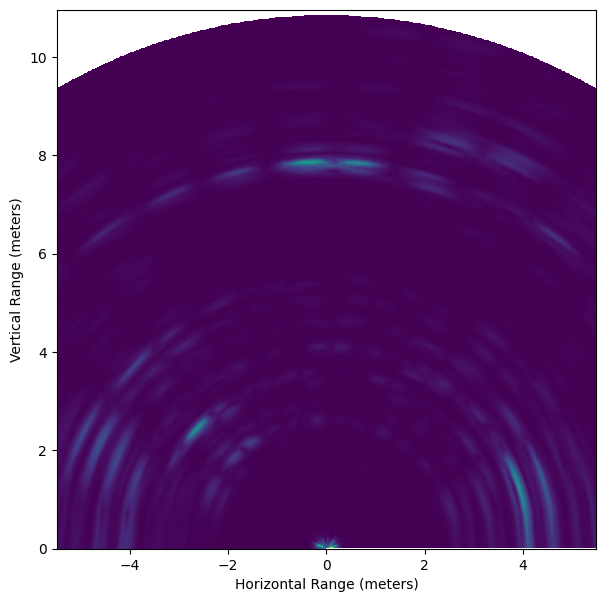

In [1]:
import json
import matplotlib.pyplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import cv2
from  scipy.interpolate import griddata
from matplotlib import transforms
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# %matplotlib ipympl

# Turn parsed JSON file into dictionary
file_str = "../data/Demo/fog/2024-04-30-15-12-30/parsed.json"
file = open(file_str)
data_dict = json.load(file)

# May print some data belonging to the "header"
# of the read "message" to choose the correct "body" 
# to read from
read_message = -1 # Depends from file to file
read_body = 1    # Depends from file to file

# Declaring Variables
antenna_range = 10.96  # Depends on the range set in the mmwave OOB demo plots tab above sensor start/stop
start_range_bin = 32
azimuth_data = data_dict["messages"][read_message]["body"][read_body]["body"]["data"]

range_bins = 128 # never changes
angle_bins = range_bins

num_sample = np.shape(azimuth_data[:])[0]
print("Number of Samples: ",num_sample)

num_antenna = int(num_sample/128) # number of virtual RX antennas, usually 8-12
# 4 virtual RX antennas for each TX antenna used
print("Number of Antennas: ",num_antenna)

# Prepare vectors for the real and imaginary values
real_azimuth = np.zeros([num_sample], dtype=np.complex_)
imag_azimuth = np.zeros([num_sample], dtype=np.complex_)
for i in (range(num_sample)):
    real_azimuth[i] = azimuth_data[i]["Re"]
    imag_azimuth[i] = azimuth_data[i]["Im"]*1j

# Combine values
azimuth_vector = real_azimuth + imag_azimuth

# Construct Radar Cube by reshaping vector into a matrix size: number range bins x number of antennas 
radar_cube = np.reshape(azimuth_vector, (range_bins, num_antenna))

angle_FFT = np.fft.fft(radar_cube,angle_bins,1) #FFT along 2nd Dimension, not range bins
angle_FFT = np.abs(np.fft.fftshift(angle_FFT,1)) #Shifts FFT so 0 frequency element is in the center
angle_FFT = cv2.transpose(angle_FFT)
# angle_FFT = cv2.transpose(angle_FFT)
# radius = int(np.sqrt((angle_FFT.shape[0] / 2)**2 + (angle_FFT.shape[1] / 2)**2))
# output = cv2.warpPolar(angle_FFT,center=(angle_FFT.shape[1]/2, angle_FFT.shape[0]/2),maxRadius=radius,dsize=(angle_FFT.shape[0], angle_FFT.shape[1]),flags=cv2.WARP_INVERSE_MAP + cv2.WARP_POLAR_LINEAR)
#X = np.arange(0, antenna_range, antenna_range/range_bins) # Range Vector
#Y = np.arange(-180, 180, 360/angle_bins) # Angle Vector
#, Y = np.meshgrid(X, Y)

#cm.set_array(angle_FFT[::-1,::-1])

range_res = antenna_range / range_bins
range_bias = 0

theta = np.arange(-1, 1 + 2 / (angle_bins) , 2 / (angle_bins-1))
#print(theta)
#print(theta.shape)
theta = np.arcsin(theta) # t * ((1 + np.sqrt(5)) / 2)
#print(theta)
range = np.array(range(range_bins)) * range_res

range_depth = range_bins * range_res
range_width, grid_res = range_depth / 2, 800

xi = np.linspace(-range_width, range_width, grid_res)
yi = np.linspace(0, range_depth, grid_res)
xii, yii = np.meshgrid(xi, yi)
print(np.shape(xi))
print(np.shape(yi))

x = np.array([range]).T * np.sin(theta)
y = np.array([range]).T * np.cos(theta)

print(np.shape(x))
print(np.shape(y))

points = np.array((x.flatten(), y.flatten())).T
values = np.array((angle_FFT, )).T
values = values.flatten()
print(np.shape(values))
Z = griddata(points
             ,values
             ,(xii,yii),"linear")

# Creating figure
fig = plt.figure(figsize =(9, 7))
ax = fig.add_subplot(111)
image = cv2.flip(Z,0)
ax.imshow(image
          #, transform=tr + ax.transData
          ,extent=[-antenna_range/2,antenna_range/2,0,antenna_range]
          )
ax.set_xlabel("Horizontal Range (meters)")
ax.set_ylabel("Vertical Range (meters)")
plt.show()

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# # Plot the surface.
# surf = ax.plot_surface(x[start_range_bin:-1], y[start_range_bin:-1], angle_FFT[start_range_bin:-1], cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.show()
